In [2]:
import sys
sys.path.append('..')

import os
from matplotlib import pyplot as plt
import numpy as np
import h5py
from utilities import mkdir
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torch_tools import WaveformDataset, try_gpu

os.chdir('..')

In [3]:
# %% Need to specify model_name first
model_name = 'Autoencoder_conv1d_pytorch'
model_dir = './Model_and_datasets_1D_STEAD' + f'/{model_name}'
data_dir = './training_datasets'

# %% load dataset
with h5py.File(data_dir + '/training_datasets_STEAD_waveform.hdf5', 'r') as f:
    time = f['time'][:]
    X_train = f['X_train'][:]
    Y_train = f['Y_train'][:]

In [4]:
# split the model based on the information provided by the model
# split the model based on the information provided by the model
with h5py.File(model_dir + '/' + f'/{model_name}_Dataset_split.hdf5', 'r') as f:
    train_size = f.attrs['train_size']
    test_size = f.attrs['test_size']
    rand_seed1 = f.attrs['rand_seed1']
    rand_seed2 = f.attrs['rand_seed2']

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, train_size=train_size, random_state=rand_seed1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=test_size, random_state=rand_seed2)

training_data = WaveformDataset(X_train, Y_train)
validate_data = WaveformDataset(X_validate, Y_validate)
test_data = WaveformDataset(X_test, Y_test)

In [5]:
# %% load model
model = torch.load(model_dir + '/' + f'{model_name}_Model.pth')

In [29]:
batch_size = 256
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=True)
device = try_gpu()
# Evaluate the test loss for the model
loss_fn = torch.nn.MSELoss()
test_loss = 0.0
model.eval()
for X, y in test_iter:
    X, y = X.to(device), y.to(device)
    if len(y.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(X)
    # calculate the loss
    loss = loss_fn(output, y)
    # update test loss
    test_loss += loss.item() * X.size(0)

test_loss = test_loss/len(test_iter.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.002611



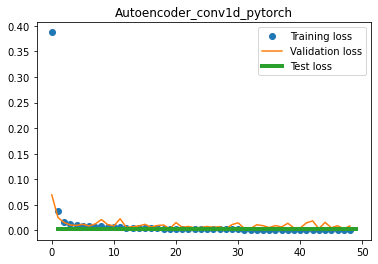

In [8]:
# Output some figures
figure_dir = model_dir + '/Figures'
mkdir(figure_dir)

# %% Show loss evolution
with h5py.File(model_dir + '/' + f'{model_name}_Training_history.hdf5', 'r') as f:
    loss = f['loss'][:]
    val_loss = f['val_loss'][:]
plt.figure()
plt.plot(loss, 'o', label='Training loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.plot([1, len(loss)], [test_loss, test_loss], '-', label='Test loss', linewidth=4)
plt.legend()
plt.title(model_name)
#plt.show()
plt.savefig(figure_dir + f"/{model_name}_Loss_evolution.png")


In [13]:
# %% predict the waveforms
# obtain one batch of test images
data_iter = iter(test_iter)
noisy_signal, clean_signal = data_iter.next()

noisy_signal, clean_signal = noisy_signal.to(device), clean_signal.to(device)

# get sample outputs
denoised_signal = model(noisy_signal)

noisy_signal = noisy_signal.to('cpu').detach().numpy()
clean_signal = clean_signal.to('cpu').detach().numpy()
denoised_signal = denoised_signal.to('cpu').detach().numpy()

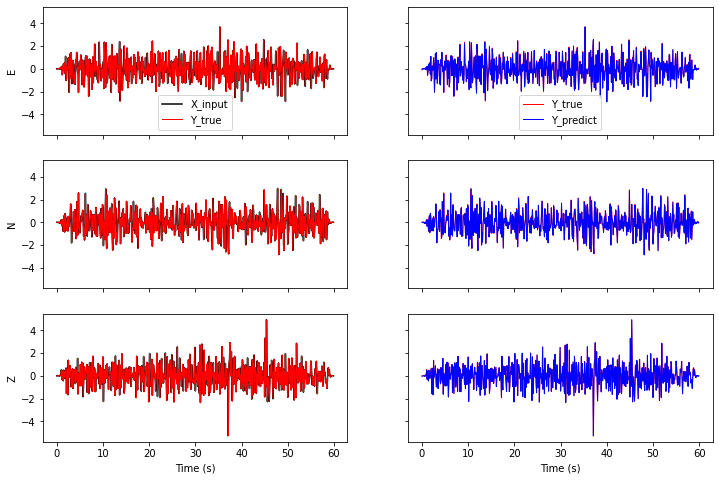

In [22]:
# %% Check the waveforms
plt.close("all")
i_model = np.random.randint(0, denoised_signal.shape[0])
fig, ax = plt.subplots(denoised_signal.shape[1], 2, sharex=True, sharey=True, num=1, figsize=(12, 8))

vmax = None
vmin = None
for i in range(noisy_signal.shape[1]):
    ax[i, 0].plot(time, noisy_signal[i_model, i, :], '-k', label='X_input', linewidth=1.5)
    ax[i, 0].plot(time, clean_signal[i_model, i, :], '-r', label='Y_true', linewidth=1)
    ax[i, 1].plot(time, clean_signal[i_model, i, :], '-r', label='Y_true', linewidth=1)
    ax[i, 1].plot(time, denoised_signal[i_model, i, :], '-b', label='Y_predict', linewidth=1)


titles = ['E', 'N', 'Z']
for i in range(noisy_signal.shape[1]):
    ax[i, 0].set_ylabel(titles[i])

ax[0, 0].legend()
ax[0, 1].legend()
ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')
#plt.show()

plt.figure(1)
plt.savefig(figure_dir + f'/{model_name}_Prediction_waveform_model_{i_model}.png')

In [26]:
denoised_signal - clean_signal

array([[[-9.16223264e-02,  2.19326643e-03, -4.11394311e-02, ...,
         -2.67724036e-02, -1.88970113e-02,  1.34135222e-01],
        [ 6.10833737e-02, -2.30241610e-02,  1.42745751e-02, ...,
         -6.31312462e-02,  2.30911888e-02, -8.44203719e-02],
        [-5.87964905e-02,  3.11126377e-03, -6.21450339e-03, ...,
          7.49512048e-03, -6.01561050e-02,  7.20130522e-02]],

       [[-2.61214738e-01, -2.01770188e-01, -1.68214661e-01, ...,
         -1.24437000e-01,  2.37044502e-01, -3.06520485e-01],
        [-3.82135081e-02, -9.97342847e-03,  5.16830795e-02, ...,
         -1.09264065e-01, -2.39280246e-01, -4.75378008e-01],
        [ 2.67874708e-03,  7.17249510e-02, -1.99568387e-02, ...,
         -5.18509583e-01, -1.54153274e+00, -3.55272604e-01]],

       [[-2.92461917e-01, -5.61908534e-02, -8.62890320e-02, ...,
          2.13752004e-02, -1.58478719e-01,  1.75436079e-01],
        [-2.23718185e-01, -1.58371628e-02,  1.13014126e-01, ...,
         -1.99957342e-02,  6.10676845e-02, -1.269

In [28]:
X_test[1,:, :] - Y_test[1, :, :]


array([[-0.2422789 , -0.70794842, -1.15830272],
       [ 0.32047611, -1.02152624,  0.92810673],
       [-0.51204365,  0.17646835, -0.31771416],
       ...,
       [ 0.00525982, -0.34430545,  0.39246317],
       [-0.41740373, -0.40886742,  0.92656017],
       [ 0.93686092,  0.17799443, -0.52421199]])